In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split

# to play the audio files
from IPython.display import Audio

from os.path import join as pjoin
import cv2
from PIL import Image

from typing import Dict, Any
import math
from copy import deepcopy

from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

import torch
from torch import LongTensor, FloatTensor, HalfTensor, Tensor
from torch.utils.data import Dataset, DataLoader
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
import inspect

from catalyst import dl, utils
import timm

from torch.fft import fft, ifft

from torchaudio.functional import bandpass_biquad
from nnAudio.Spectrogram import CQT1992v2
import torchvision.models as models

%matplotlib inline

sampling_rate = 22050

In [22]:
data_path = pd.read_csv("data_path.csv", #nrows=500
                       )
data_path = data_path.rename(columns={'Path':'path', 'Emotions':'emotions'})

dict_of_class = {
    'neutral': 0,
    'sad': 1,
    'happy': 2,
    'angry': 3,
    'disgust': 4,
    'fear': 5,
    'surprise': 6,
    'calm': 0,
    }

data_path['target'] = data_path.apply(lambda x: dict_of_class[x.emotions], axis=1)
dict_of_class.pop('calm')
n_of_class_emotion = len(dict_of_class)
data_path['preloaded_id'] = data_path.index.values

train_original, test_original = train_test_split(data_path, test_size=0.2, stratify=data_path[['emotions', 'dataset']].astype(str).apply('_'.join, axis=1), random_state=42)
train_original, valid_original = train_test_split(train_original, test_size=0.1, stratify=train_original[['emotions', 'dataset']].astype(str).apply('_'.join, axis=1), random_state=42)
train_original.shape[0], valid_original.shape[0], test_original.shape[0]

(8756, 973, 2433)

In [23]:
preloaded_audios = []
for path in tqdm(data_path.path):
    preloaded_audios.append(librosa.load(path, res_type='kaiser_fast'))

  0%|          | 0/12162 [00:00<?, ?it/s]

In [34]:
def split_dataset(input_df, sec_each_sample=1, overlapping=0.5):
    
    #dataset = pd.DataFrame(columns=['path','target', 'start', 'end'])
    dataset = []
    for row in input_df.values:
        sec_y = librosa.get_duration(filename=row[1])
        if (sec_y/sec_each_sample-0.5) > 1:
            audio_df = (sampling_rate*sec_each_sample*pd.DataFrame(
                [(i*overlapping, (i*overlapping+1)) for i in range(1, int(2*sec_y/sec_each_sample-2))]+
                [(max(sec_y/sec_each_sample-1.5, 0), sec_y/sec_each_sample-0.5)]
            , columns=['start', 'end'])).astype(int)
        else:
            audio_df = (sampling_rate*sec_each_sample*pd.DataFrame(
                [(max(sec_y/sec_each_sample-1, 0), sec_y/sec_each_sample)]
            , columns=['start', 'end'])).astype(int)
        audio_df['path'] = row[1]
        audio_df['target'] = row[3]
        audio_df['preloaded_id'] = row[4]
        dataset.append(audio_df)
    return pd.concat(dataset).reset_index(drop=True)

In [35]:
%%time
train = split_dataset(train_original)
valid = split_dataset(valid_original)
test = split_dataset(test_original)

CPU times: user 26.3 s, sys: 351 ms, total: 26.7 s
Wall time: 26.6 s


In [37]:
train.end[(train.end - train.start) > 22050] = train.start[(train.end - train.start) > 22050]+22050
valid.end[(valid.end - valid.start) > 22050] = valid.start[(valid.end - valid.start) > 22050]+22050
test.end[(test.end - test.start) > 22050] = test.start[(test.end - test.start) > 22050]+22050

/tmp/ipykernel_103692/777247130.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.end[(train.end - train.start) > 22050] = train.start[(train.end - train.start) > 22050]+22050
/tmp/ipykernel_103692/777247130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid.end[(valid.end - valid.start) > 22050] = valid.start[(valid.end - valid.start) > 22050]+22050
/tmp/ipykernel_103692/777247130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [43]:
#PERIOD=5

class Emotional_Dataset(Dataset):
    def __init__(self, dataset, target=None):
        self.path = dataset.path.values
        if target is not None:
            self.target = FloatTensor(np.array(target))
        else:
            self.target = None
        self.index = dataset.path
        self.start = dataset.start.values
        self.end = dataset.end.values
        self.preloaded_id = dataset.preloaded_id.values
        
    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        
        #y, sampling_rate = librosa.load(self.path[idx], res_type='kaiser_fast')
        y, sampling_rate = preloaded_audios[self.preloaded_id[idx]]
        
        y = y[self.start[idx]:self.end[idx]]

            
        sample = {'features':  FloatTensor(np.expand_dims(y, 0))}
        if self.target is not None:
            sample['targets'] = int(self.target[idx])#labels.flatten()
            
        return sample

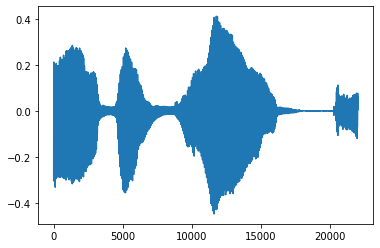

In [44]:
A_temp = Emotional_Dataset(train, train.target)
smp = A_temp[0]
wave, labl = smp['features'].numpy(), smp['targets']
plt.plot(wave[0]);

In [45]:
# class Preloaded_Emotional_Dataset(Dataset):
#     def __init__(self, em_dataset):
        
#         self.preloaded_spec = []
#         for i in tqdm(range(len(em_dataset))):
#             self.preloaded_spec.append(em_dataset[i])
            
#     def __len__(self):
#         return len(self.preloaded_spec)

#     def __getitem__(self, idx):
#         return self.preloaded_spec[idx]

In [46]:
class GeM(nn.Module):
    '''
    Code modified from the 2d code in
    https://amaarora.github.io/2020/08/30/gempool.html
    '''
    def __init__(self, kernel_size=8, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.kernel_size = kernel_size
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool1d(x.clamp(min=eps).pow(p), self.kernel_size).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'
    
class CNN1d(nn.Module):
    """1D convolutional neural network. Classifier of the gravitational waves.
    Architecture from there https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.120.141103
    """

    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=441),
            nn.BatchNorm1d(64),
            nn.SiLU(),
        )
        self.cnn2 = nn.Sequential(
            nn.Conv1d(64, 64, kernel_size=32),
            GeM(kernel_size=8),
            nn.BatchNorm1d(64),
            nn.SiLU(),
        )
        self.cnn3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=32),
            nn.BatchNorm1d(128),
            nn.SiLU(),
        )
        self.cnn4 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=16),
            GeM(kernel_size=6),
            nn.BatchNorm1d(128),
            nn.SiLU(),
        )
        self.cnn5 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=16),
            nn.BatchNorm1d(256),
            nn.SiLU(),
        )
        self.cnn6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=16),
            GeM(kernel_size=4),
            nn.BatchNorm1d(256),
            nn.SiLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(26112, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.25),
            nn.SiLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.Dropout(0.25),
            nn.SiLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64, n_of_class_emotion),
        )

    def forward(self, x, pos=None):
        x = self.cnn1(x)
        x = self.cnn2(x)
        x = self.cnn3(x)
        x = self.cnn4(x)
        x = self.cnn5(x)
        x = self.cnn6(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
    
class TimmModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.wave_model = CNN1d()
        #self.img_model = timm.create_model('tf_efficientnet_b0_ns', pretrained=True)
        #self.img_model.conv_stem.stride = (1,2)
        #self.classifier = nn.Sequential(nn.ELU(), nn.Dropout(0.2), nn.Linear(in_features=1000, out_features=1))
        self.classifier = nn.Identity()
        
    def forward(self, features):
        return self.classifier(self.wave_model(features))#.flatten()

In [47]:
!nvidia-smi

Sat Oct  2 23:45:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000001:00:00.0 Off |                    0 |
| N/A   26C    P0    36W / 250W |  14767MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [48]:
EXP_PATH = '1d'


#for i, (fold_train, fold_val) in enumerate(cv_data):
#print('Fold', i)
#if i==0:
FOLD_PATH = f'{EXP_PATH}'

batch_size=200


loaders = {
    "train": DataLoader(Emotional_Dataset(train, train['target']),
                        #worker_init_fn=worker_init_fn,
                        batch_size=batch_size, shuffle=True, drop_last=True, num_workers=6, pin_memory=True),
    "valid": DataLoader(Emotional_Dataset(valid, valid['target']), 
                        #worker_init_fn=worker_init_fn,
                        batch_size=batch_size, shuffle=False, drop_last=False, num_workers=6, pin_memory=True),
}

model =  TimmModel()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
criterion =torch.nn.CrossEntropyLoss()#nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=0, factor=0.3, min_lr=1e-8)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=3e-5)

callbacks = [
    #dl.AUCCallback(input_key="logits", target_key="targets",),
    dl.AccuracyCallback(
            input_key="logits", target_key="targets", num_classes=n_of_class_emotion
        ),
    dl.OptimizerCallback('loss'),
    dl.SchedulerCallback(loader_key='valid', metric_key='accuracy', mode='epoch'),
    dl.CheckpointCallback(loader_key='valid', metric_key='accuracy', minimize=False, save_n_best=3, mode='model', use_runner_logdir=True, use_logdir_postfix=True, ),
    dl.EarlyStoppingCallback(patience=4, loader_key="valid", metric_key="accuracy", minimize=False),
    dl.TimerCallback()
]
runner = dl.SupervisedRunner(input_key="features", target_key="targets", output_key="logits", loss_key="loss", )
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=100,#99999,#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    callbacks=callbacks,
    #engine=dl.DeviceEngine("cpu"),
    logdir=f"{FOLD_PATH}",
    valid_loader="valid",
    valid_metric="accuracy",
    minimize_valid_metric=False,
    verbose=True,
    load_best_on_end=True,
    amp=True,
)

1/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (1/100) accuracy: 0.24731405079364777 | accuracy/std: 0.041571475833982234 | accuracy01: 0.24731405079364777 | accuracy01/std: 0.041571475833982234 | accuracy03: 0.6152892708778381 | accuracy03/std: 0.05036048104849416 | accuracy05: 0.8465288877487183 | accuracy05/std: 0.03026696010726676 | loss: 1.854714035987854 | loss/mean: 1.854714035987854 | loss/std: 0.05220909139911498 | lr: 1e-05 | momentum: 0.9


1/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (1/100) accuracy: 0.32551318407058716 | accuracy/std: 0.04730389306806859 | accuracy01: 0.32551318407058716 | accuracy01/std: 0.04730389306806859 | accuracy03: 0.6730204820632935 | accuracy03/std: 0.046491545044961356 | accuracy05: 0.8662023544311523 | accuracy05/std: 0.04269809720129196 | loss: 1.7914029359817505 | loss/mean: 1.7914029359817505 | loss/std: 0.038798907057176334 | lr: 1e-05 | momentum: 0.9
* Epoch (1/100) lr: 1e-05 | momentum: 0.9


2/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (2/100) accuracy: 0.3251652717590332 | accuracy/std: 0.034997380091520106 | accuracy01: 0.3251652717590332 | accuracy01/std: 0.034997380091520106 | accuracy03: 0.6939669251441956 | accuracy03/std: 0.031075844296331947 | accuracy05: 0.8852065801620483 | accuracy05/std: 0.020544636607355515 | loss: 1.7352198362350464 | loss/mean: 1.7352198362350464 | loss/std: 0.033025492827068986 | lr: 1e-05 | momentum: 0.9


2/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (2/100) accuracy: 0.35997065901756287 | accuracy/std: 0.050995265286107885 | accuracy01: 0.35997065901756287 | accuracy01/std: 0.050995265286107885 | accuracy03: 0.7052785754203796 | accuracy03/std: 0.0492527173968478 | accuracy05: 0.8870967626571655 | accuracy05/std: 0.03216385880838678 | loss: 1.7105122804641724 | loss/mean: 1.7105122804641724 | loss/std: 0.05380332658584254 | lr: 1e-05 | momentum: 0.9
* Epoch (2/100) lr: 1e-05 | momentum: 0.9


3/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (3/100) accuracy: 0.37347105145454407 | accuracy/std: 0.035929062107408434 | accuracy01: 0.37347105145454407 | accuracy01/std: 0.035929062107408434 | accuracy03: 0.7268595099449158 | accuracy03/std: 0.0314145228726803 | accuracy05: 0.9042974710464478 | accuracy05/std: 0.022529652326049136 | loss: 1.6541743278503418 | loss/mean: 1.6541743278503418 | loss/std: 0.03906597358739279 | lr: 1e-05 | momentum: 0.9


3/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (3/100) accuracy: 0.3812316656112671 | accuracy/std: 0.05651231439465713 | accuracy01: 0.3812316656112671 | accuracy01/std: 0.05651231439465713 | accuracy03: 0.730205237865448 | accuracy03/std: 0.060271958236356185 | accuracy05: 0.9057917594909668 | accuracy05/std: 0.035353983858206234 | loss: 1.654166340827942 | loss/mean: 1.654166340827942 | loss/std: 0.06147619508238948 | lr: 1e-05 | momentum: 0.9
* Epoch (3/100) lr: 1e-05 | momentum: 0.9


4/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (4/100) accuracy: 0.4140082597732544 | accuracy/std: 0.032592689064304736 | accuracy01: 0.4140082597732544 | accuracy01/std: 0.032592689064304736 | accuracy03: 0.754917323589325 | accuracy03/std: 0.028884685578012263 | accuracy05: 0.9109503626823425 | accuracy05/std: 0.02058399684257781 | loss: 1.587618112564087 | loss/mean: 1.587618112564087 | loss/std: 0.037835378643761595 | lr: 1e-05 | momentum: 0.9


4/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (4/100) accuracy: 0.4164222776889801 | accuracy/std: 0.05938053160518922 | accuracy01: 0.4164222776889801 | accuracy01/std: 0.05938053160518922 | accuracy03: 0.7518328428268433 | accuracy03/std: 0.05673764595664444 | accuracy05: 0.9112902879714966 | accuracy05/std: 0.034322884851592496 | loss: 1.5884655714035034 | loss/mean: 1.5884655714035034 | loss/std: 0.06645577821209628 | lr: 1e-05 | momentum: 0.9
* Epoch (4/100) lr: 1e-05 | momentum: 0.9


5/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (5/100) accuracy: 0.44694215059280396 | accuracy/std: 0.03271135144878322 | accuracy01: 0.44694215059280396 | accuracy01/std: 0.03271135144878322 | accuracy03: 0.7684297561645508 | accuracy03/std: 0.024971843381381077 | accuracy05: 0.9193801283836365 | accuracy05/std: 0.01946185764158835 | loss: 1.5330225229263306 | loss/mean: 1.5330225229263306 | loss/std: 0.03752985643914849 | lr: 1e-05 | momentum: 0.9


5/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (5/100) accuracy: 0.40615835785865784 | accuracy/std: 0.06127178141055206 | accuracy01: 0.40615835785865784 | accuracy01/std: 0.06127178141055206 | accuracy03: 0.729105532169342 | accuracy03/std: 0.058005175294466825 | accuracy05: 0.9138562679290771 | accuracy05/std: 0.029735617273253613 | loss: 1.5800970792770386 | loss/mean: 1.5800970792770386 | loss/std: 0.0785796314421919 | lr: 1e-05 | momentum: 0.9
* Epoch (5/100) lr: 3e-06 | momentum: 0.9


6/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (6/100) accuracy: 0.4712809920310974 | accuracy/std: 0.03457921724886151 | accuracy01: 0.4712809920310974 | accuracy01/std: 0.03457921724886151 | accuracy03: 0.7885537147521973 | accuracy03/std: 0.028916533294123612 | accuracy05: 0.9254544973373413 | accuracy05/std: 0.018022406251843814 | loss: 1.4883413314819336 | loss/mean: 1.4883413314819336 | loss/std: 0.037952857374935936 | lr: 3e-06 | momentum: 0.9


6/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (6/100) accuracy: 0.43438416719436646 | accuracy/std: 0.06500987941543301 | accuracy01: 0.43438416719436646 | accuracy01/std: 0.06500987941543301 | accuracy03: 0.7727272510528564 | accuracy03/std: 0.05828410317056127 | accuracy05: 0.9164222478866577 | accuracy05/std: 0.039404629101214096 | loss: 1.541047215461731 | loss/mean: 1.541047215461731 | loss/std: 0.07697135211151089 | lr: 3e-06 | momentum: 0.9
* Epoch (6/100) lr: 3e-06 | momentum: 0.9


7/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (7/100) accuracy: 0.4801652729511261 | accuracy/std: 0.03427556565239818 | accuracy01: 0.4801652729511261 | accuracy01/std: 0.03427556565239818 | accuracy03: 0.7971073985099792 | accuracy03/std: 0.026882237431419483 | accuracy05: 0.9291322231292725 | accuracy05/std: 0.017938260625691236 | loss: 1.4705837965011597 | loss/mean: 1.4705837965011597 | loss/std: 0.03731291867697181 | lr: 3e-06 | momentum: 0.9


7/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (7/100) accuracy: 0.4376832842826843 | accuracy/std: 0.06092271232191485 | accuracy01: 0.4376832842826843 | accuracy01/std: 0.06092271232191485 | accuracy03: 0.7756597995758057 | accuracy03/std: 0.05130895260566496 | accuracy05: 0.918255090713501 | accuracy05/std: 0.03270141961336966 | loss: 1.5365263223648071 | loss/mean: 1.5365263223648071 | loss/std: 0.07395101039995008 | lr: 3e-06 | momentum: 0.9
* Epoch (7/100) lr: 3e-06 | momentum: 0.9


8/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (8/100) accuracy: 0.4889669418334961 | accuracy/std: 0.034329678123639754 | accuracy01: 0.4889669418334961 | accuracy01/std: 0.034329678123639754 | accuracy03: 0.7990495562553406 | accuracy03/std: 0.02906531923646376 | accuracy05: 0.9314875602722168 | accuracy05/std: 0.016472771351027565 | loss: 1.456018328666687 | loss/mean: 1.456018328666687 | loss/std: 0.039399105082403026 | lr: 3e-06 | momentum: 0.9


8/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (8/100) accuracy: 0.4439149498939514 | accuracy/std: 0.061989348417675345 | accuracy01: 0.4439149498939514 | accuracy01/std: 0.061989348417675345 | accuracy03: 0.7705278396606445 | accuracy03/std: 0.05023483363770739 | accuracy05: 0.917155385017395 | accuracy05/std: 0.028755761555540427 | loss: 1.5388213396072388 | loss/mean: 1.5388213396072388 | loss/std: 0.0731244419702955 | lr: 3e-06 | momentum: 0.9
* Epoch (8/100) lr: 3e-06 | momentum: 0.9


9/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (9/100) accuracy: 0.49739667773246765 | accuracy/std: 0.035508264022831214 | accuracy01: 0.49739667773246765 | accuracy01/std: 0.035508264022831214 | accuracy03: 0.8064875602722168 | accuracy03/std: 0.027669248638922048 | accuracy05: 0.9314875602722168 | accuracy05/std: 0.016610173530330428 | loss: 1.4439879655838013 | loss/mean: 1.4439879655838013 | loss/std: 0.03609769093792133 | lr: 3e-06 | momentum: 0.9


9/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (9/100) accuracy: 0.4431818127632141 | accuracy/std: 0.06217985730380147 | accuracy01: 0.4431818127632141 | accuracy01/std: 0.06217985730380147 | accuracy03: 0.7778592109680176 | accuracy03/std: 0.05430730702487462 | accuracy05: 0.9200879335403442 | accuracy05/std: 0.03514952375442443 | loss: 1.5286014080047607 | loss/mean: 1.5286014080047607 | loss/std: 0.07835572499741622 | lr: 3e-06 | momentum: 0.9
* Epoch (9/100) lr: 9e-07 | momentum: 0.9


10/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (10/100) accuracy: 0.5049586892127991 | accuracy/std: 0.033213595981906756 | accuracy01: 0.5049586892127991 | accuracy01/std: 0.033213595981906756 | accuracy03: 0.8107024431228638 | accuracy03/std: 0.025449437171277647 | accuracy05: 0.9343801736831665 | accuracy05/std: 0.016496906122074124 | loss: 1.42825448513031 | loss/mean: 1.42825448513031 | loss/std: 0.03489569049322276 | lr: 9e-07 | momentum: 0.9


10/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (10/100) accuracy: 0.4417155385017395 | accuracy/std: 0.059236740541691035 | accuracy01: 0.4417155385017395 | accuracy01/std: 0.059236740541691035 | accuracy03: 0.7793254852294922 | accuracy03/std: 0.05166558794180339 | accuracy05: 0.9193547964096069 | accuracy05/std: 0.036380592470798466 | loss: 1.522512435913086 | loss/mean: 1.522512435913086 | loss/std: 0.07713511633191962 | lr: 9e-07 | momentum: 0.9
* Epoch (10/100) lr: 2.6999999999999996e-07 | momentum: 0.9


11/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (11/100) accuracy: 0.509173572063446 | accuracy/std: 0.038222344859820095 | accuracy01: 0.509173572063446 | accuracy01/std: 0.038222344859820095 | accuracy03: 0.8140082359313965 | accuracy03/std: 0.030313183487184876 | accuracy05: 0.934876024723053 | accuracy05/std: 0.017668836909127347 | loss: 1.4243310689926147 | loss/mean: 1.4243310689926147 | loss/std: 0.042810205147649404 | lr: 2.6999999999999996e-07 | momentum: 0.9


11/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (11/100) accuracy: 0.445381224155426 | accuracy/std: 0.061422009371873074 | accuracy01: 0.445381224155426 | accuracy01/std: 0.061422009371873074 | accuracy03: 0.7804251909255981 | accuracy03/std: 0.05013625281737975 | accuracy05: 0.9193547964096069 | accuracy05/std: 0.03509149950598452 | loss: 1.5239559412002563 | loss/mean: 1.5239559412002563 | loss/std: 0.07525043532643637 | lr: 2.6999999999999996e-07 | momentum: 0.9
* Epoch (11/100) lr: 2.6999999999999996e-07 | momentum: 0.9


12/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (12/100) accuracy: 0.513801634311676 | accuracy/std: 0.036187960587956924 | accuracy01: 0.513801634311676 | accuracy01/std: 0.036187960587956924 | accuracy03: 0.8127685785293579 | accuracy03/std: 0.025218172593391437 | accuracy05: 0.9332231283187866 | accuracy05/std: 0.01721148970954919 | loss: 1.4205131530761719 | loss/mean: 1.4205131530761719 | loss/std: 0.04199124491405027 | lr: 2.6999999999999996e-07 | momentum: 0.9


12/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (12/100) accuracy: 0.4450146555900574 | accuracy/std: 0.058346136142277946 | accuracy01: 0.4450146555900574 | accuracy01/std: 0.058346136142277946 | accuracy03: 0.7796920537948608 | accuracy03/std: 0.05093641736800683 | accuracy05: 0.9175219535827637 | accuracy05/std: 0.03363592676755082 | loss: 1.5224578380584717 | loss/mean: 1.5224578380584717 | loss/std: 0.07628357977977113 | lr: 2.6999999999999996e-07 | momentum: 0.9
* Epoch (12/100) lr: 8.099999999999998e-08 | momentum: 0.9


13/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (13/100) accuracy: 0.5102892518043518 | accuracy/std: 0.03773241927962607 | accuracy01: 0.5102892518043518 | accuracy01/std: 0.03773241927962607 | accuracy03: 0.8149173259735107 | accuracy03/std: 0.028160274741664177 | accuracy05: 0.9342561960220337 | accuracy05/std: 0.0178803833457881 | loss: 1.418895959854126 | loss/mean: 1.418895959854126 | loss/std: 0.04260233262105297 | lr: 8.099999999999998e-08 | momentum: 0.9


13/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (13/100) accuracy: 0.44904690980911255 | accuracy/std: 0.061766475946718906 | accuracy01: 0.44904690980911255 | accuracy01/std: 0.061766475946718906 | accuracy03: 0.7767595052719116 | accuracy03/std: 0.05467359197580905 | accuracy05: 0.9160556793212891 | accuracy05/std: 0.03729028422875346 | loss: 1.5200395584106445 | loss/mean: 1.5200395584106445 | loss/std: 0.07787070923231146 | lr: 8.099999999999998e-08 | momentum: 0.9
* Epoch (13/100) lr: 8.099999999999998e-08 | momentum: 0.9


14/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (14/100) accuracy: 0.5082231163978577 | accuracy/std: 0.03335243158825965 | accuracy01: 0.5082231163978577 | accuracy01/std: 0.03335243158825965 | accuracy03: 0.8172313570976257 | accuracy03/std: 0.026340270775785494 | accuracy05: 0.934586763381958 | accuracy05/std: 0.018109173825086214 | loss: 1.4186409711837769 | loss/mean: 1.4186409711837769 | loss/std: 0.038657561471425135 | lr: 8.099999999999998e-08 | momentum: 0.9


14/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (14/100) accuracy: 0.44904690980911255 | accuracy/std: 0.06352259353224413 | accuracy01: 0.44904690980911255 | accuracy01/std: 0.06352259353224413 | accuracy03: 0.7793254852294922 | accuracy03/std: 0.052040181890817765 | accuracy05: 0.9204545021057129 | accuracy05/std: 0.03341511557667642 | loss: 1.522527813911438 | loss/mean: 1.522527813911438 | loss/std: 0.07668521614228045 | lr: 8.099999999999998e-08 | momentum: 0.9
* Epoch (14/100) lr: 2.4299999999999996e-08 | momentum: 0.9


15/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (15/100) accuracy: 0.511487603187561 | accuracy/std: 0.038039720917558535 | accuracy01: 0.511487603187561 | accuracy01/std: 0.038039720917558535 | accuracy03: 0.8152065873146057 | accuracy03/std: 0.030209244896655114 | accuracy05: 0.9357851147651672 | accuracy05/std: 0.01802249556752441 | loss: 1.4204844236373901 | loss/mean: 1.4204844236373901 | loss/std: 0.03808136416754734 | lr: 2.4299999999999996e-08 | momentum: 0.9


15/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (15/100) accuracy: 0.4472140669822693 | accuracy/std: 0.060404685569799506 | accuracy01: 0.4472140669822693 | accuracy01/std: 0.060404685569799506 | accuracy03: 0.7793254852294922 | accuracy03/std: 0.049379244920794374 | accuracy05: 0.918255090713501 | accuracy05/std: 0.03666463589804401 | loss: 1.5238398313522339 | loss/mean: 1.5238398313522339 | loss/std: 0.07580607390248577 | lr: 2.4299999999999996e-08 | momentum: 0.9
* Epoch (15/100) lr: 1e-08 | momentum: 0.9


16/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (16/100) accuracy: 0.5074793100357056 | accuracy/std: 0.0387792755011618 | accuracy01: 0.5074793100357056 | accuracy01/std: 0.0387792755011618 | accuracy03: 0.8140082359313965 | accuracy03/std: 0.02952591574854336 | accuracy05: 0.9353718757629395 | accuracy05/std: 0.014995705276235914 | loss: 1.4214107990264893 | loss/mean: 1.4214107990264893 | loss/std: 0.04589237072351637 | lr: 1e-08 | momentum: 0.9


16/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (16/100) accuracy: 0.44611436128616333 | accuracy/std: 0.058356115740812294 | accuracy01: 0.44611436128616333 | accuracy01/std: 0.058356115740812294 | accuracy03: 0.7789589166641235 | accuracy03/std: 0.053334853682583665 | accuracy05: 0.9189882278442383 | accuracy05/std: 0.03653100097006471 | loss: 1.5223323106765747 | loss/mean: 1.5223323106765747 | loss/std: 0.07600799515981836 | lr: 1e-08 | momentum: 0.9
* Epoch (16/100) lr: 1e-08 | momentum: 0.9


17/100 * Epoch (train):   0%|          | 0/121 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


train (17/100) accuracy: 0.5130165219306946 | accuracy/std: 0.031443101741300064 | accuracy01: 0.5130165219306946 | accuracy01/std: 0.031443101741300064 | accuracy03: 0.81351238489151 | accuracy03/std: 0.031193490560414577 | accuracy05: 0.932975172996521 | accuracy05/std: 0.018459394054358983 | loss: 1.4223289489746094 | loss/mean: 1.4223289489746094 | loss/std: 0.039433519811957335 | lr: 1e-08 | momentum: 0.9


17/100 * Epoch (valid):   0%|          | 0/14 [00:00<?, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


valid (17/100) accuracy: 0.446480929851532 | accuracy/std: 0.06348002315051546 | accuracy01: 0.446480929851532 | accuracy01/std: 0.06348002315051546 | accuracy03: 0.7811583280563354 | accuracy03/std: 0.053761519552091686 | accuracy05: 0.9189882278442383 | accuracy05/std: 0.03328775835270912 | loss: 1.5214709043502808 | loss/mean: 1.5214709043502808 | loss/std: 0.07646036964610882 | lr: 1e-08 | momentum: 0.9
* Epoch (17/100) lr: 1e-08 | momentum: 0.9
Top best models:
1d/checkpoints/train.13.pth	0.4490
1d/checkpoints/train.14.pth	0.4490
1d/checkpoints/train.15.pth	0.4472


In [49]:
def predict_loader(model, loader):
    pred = runner.predict_loader(model=model, loader=loader)
    #pred = [torch.sigmoid(batch['logits'].detach().cpu().float()).numpy() for batch in tqdm(pred)] 
    pred = [batch['logits'].detach().cpu().float().numpy() for batch in tqdm(pred)] 
    pred = pd.Series(np.concatenate(pred, 0), index = loader.dataset.index)
    return pred


def write_prediction(pred, name, exp_path='logs'):
    sub = pd.read_csv('g2net-gravitational-wave-detection/sample_submission.csv').set_index('id')
    sub['target'] = pred
    sub.to_csv(f'{exp_path}/sub_{name}.csv')
    

    
def get_valid_logs(exp_path='logs'):
    valid_log = pd.read_csv(f'{exp_path}/logs/valid.csv')#.set_index('step')
    if ('step' == valid_log['step']).any():
        valid_log = valid_log.iloc[valid_log[valid_log['step'] == 'step'].index.max()+1:].reset_index(drop=True)
    return valid_log

In [74]:
test_dataloader = DataLoader(Emotional_Dataset(test, test['target']), 
                    #worker_init_fn=worker_init_fn,
                    batch_size=batch_size, shuffle=False, drop_last=False, num_workers=6, pin_memory=False)
model =  TimmModel()
model.load_state_dict(torch.load(f'{EXP_PATH}/checkpoints/best.pth')['model_state_dict'])
model = model.eval().cuda()
score = get_valid_logs(EXP_PATH)['accuracy'].max()
#pred = predict_loader(model, test_dataloader)
#write_prediction(pred, f'best_{score}', EXP_PATH)

pred = runner.predict_loader(model=model, loader=test_dataloader)
#pred = [torch.sigmoid(batch['logits'].detach().cpu().float()).numpy() for batch in tqdm(pred)] 
pred = [batch['logits'].detach().cpu().float().numpy() for batch in tqdm(pred)] 


pred = pd.DataFrame(np.concatenate(pred, 0), index = test_dataloader.dataset.index)

test['pred'] = pred.apply(lambda row: row.argmax(), axis=1).values
from sklearn.metrics import accuracy_score
print(accuracy_score(test.target, test.pred))

0it [00:00, ?it/s]

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


0.4550595238095238


In [75]:
pred = pred.reset_index()

In [81]:
pred

,path,0,1,2,3,4,5,6
0,cremad/AudioWAV/1047_TSI_SAD_XX.wav,0.234065,0.736190,-0.707279,-0.831850,0.497806,0.070839,-0.244048
1,cremad/AudioWAV/1070_TSI_NEU_XX.wav,-0.151495,-0.339816,-0.167538,0.267519,0.963063,-0.338073,0.046682
2,cremad/AudioWAV/1070_TSI_NEU_XX.wav,0.046191,-0.434670,0.156462,0.485132,0.760138,-0.269214,-0.137838
3,cremad/AudioWAV/1009_IEO_DIS_HI.wav,-0.610656,0.121351,-0.076099,-0.180354,-0.150528,0.783978,-0.023780
4,cremad/AudioWAV/1009_IEO_DIS_HI.wav,-0.446101,-0.913102,0.319182,1.051095,-1.047850,0.532047,-0.424845
...,...,...,...,...,...,...,...,...
6715,ravdess-emotional-speech-audio/audio_speech_ac...,0.029045,0.234388,-0.175834,-0.552986,-0.017697,0.099122,0.122666
6716,ravdess-emotional-speech-audio/audio_speech_ac...,0.221068,0.237919,-0.420500,-0.522327,-0.056365,-0.116304,0.281170
6717,cremad/AudioWAV/1074_TIE_HAP_XX.wav,-1.016811,-0.482729,1.032654,0.590211,-0.805177,0.817743,0.159970
6718,cremad/AudioWAV/1074_TIE_HAP_XX.wav,-1.416423,-0.952919,0.788940,1.085400,-1.489691,1.314424,-0.572967


In [80]:
pred[pred.path == 'cremad/AudioWAV/1074_TIE_HAP_XX.wav'].set_index('path').mean().argmax()

3

In [68]:
pred = pred.groupby(by=['path']).apply(lambda a: a.mean()).reset_index()

In [72]:
test_original['pred'] = pred.set_index('path').apply(lambda row: row.argmax(), axis=1).values

/tmp/ipykernel_103692/950401255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_original['pred'] = pred.set_index('path').apply(lambda row: row.argmax(), axis=1).values


In [73]:
print(accuracy_score(test_original.target, test_original.pred))

0.15659679408138102


In [16]:
inv_class_dict = {}
for k in dict_of_class:
    inv_class_dict[dict_of_class[k]]=k

In [17]:
Personal = Emotional_Dataset(['personal/disgust_eng.wav'], [1])
smp = Personal[0]
img, labl = smp['features'].unsqueeze(0).to('cuda:0'), smp['targets']

inv_class_dict[int(model(img).argmax().cpu().data.numpy())]

'fear'

In [ ]:
'a'